# Modeling 

This notebook will run models after dropping the feature high_school_5_year_graduation_rate_total

In [33]:
# standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#%matplotlib inline
import seaborn as sns 

# statsmodels imports
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

# sklearn imports
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, SCORERS
from sklearn.model_selection import RandomizedSearchCV

# pickle
import pickle

# lime
#import lime

# turn off warnings
import warnings
warnings.simplefilter('ignore', category = DeprecationWarning)
warnings.simplefilter('ignore', category = FutureWarning)

# plot parameters
plt.rcParams['figure.figsize'] = 20, 16
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 25
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.size'] = 16
#color = '#003f5a'

# functions from .py file
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
import src.eda_functions as fun

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


read in merged_data file

In [2]:
train_set = pd.read_csv('../../data/train_set.csv', )
val_set = pd.read_csv('../../data/val_set.csv')
test_set = pd.read_csv('../../data/test_set.csv')

In [3]:
train_set['cohort'] = train_set['cohort'].astype('object')
val_set['cohort'] = val_set['cohort'].astype('object')
test_set['cohort'] = test_set['cohort'].astype('object')

Separate X and y for each set

In [4]:
X_train = train_set.drop(['high_school_4_year_graduation_rate_total', 
                         'high_school_5_year_graduation_rate_total'], axis=1)
y_train = train_set.high_school_4_year_graduation_rate_total


X_val = val_set.drop(['high_school_4_year_graduation_rate_total', 
                        'high_school_5_year_graduation_rate_total'], axis=1)
y_val = val_set.high_school_4_year_graduation_rate_total

X_test = test_set.drop(['high_school_4_year_graduation_rate_total', 
                         'high_school_5_year_graduation_rate_total'], axis=1)
y_test = test_set.high_school_4_year_graduation_rate_total

## Replace NaNs with mean()


Use SimpleImputer to replace NaNs with mean value

In [5]:
# identify features
train_num = X_train.select_dtypes(['float64', 'int64'])
val_num = X_val.select_dtypes(['float64', 'int64'])
test_num = X_test.select_dtypes(['float64', 'int64'])

In [6]:
from sklearn.impute import SimpleImputer

# Create an imputer object with a median filling strategy
imputer = SimpleImputer(strategy='median')

# Train on the training features
imputer.fit(train_num)

# Transform both training data and testing data
train_imp= imputer.transform(train_num)
val_imp = imputer.transform(val_num)
test_imp = imputer.transform(test_num)

# Creating this DataFrame is not necessary its only to show the result of the ohe
X_train_imp = pd.DataFrame(train_imp, columns=train_num.columns, index=X_train.index)
X_val_imp = pd.DataFrame(val_imp, columns=val_num.columns, index=X_val.index)
X_test_imp = pd.DataFrame(test_imp, columns=test_num.columns, index=X_test.index)


# Scaling Numeric features
- Standard Scaler

In [7]:
X_train_num = X_train_imp.select_dtypes(['float64', 'int64'])
X_val_num = X_val_imp.select_dtypes(['float64', 'int64'])
X_test_num = X_test_imp.select_dtypes(['float64', 'int64'])

In [8]:
ss = StandardScaler()

# Train on the training features
ss.fit(X_train_num)

# Transform both training data and testing data
X_train_sc= ss.transform(X_train_num)
X_val_sc = ss.transform(X_val_num)
X_test_sc = ss.transform(X_test_num)


X_train_sc = pd.DataFrame(X_train_sc, columns=X_train_num.columns, index=X_train.index)
X_val_sc = pd.DataFrame(X_val_sc, columns=X_val_num.columns, index=X_val.index)
X_test_sc = pd.DataFrame(X_test_sc, columns=X_test_num.columns, index=X_test.index)


# Encoding Categorical features

In [9]:
# identify features
X_train_obj = X_train.select_dtypes(['object']).astype('category')
X_val_obj = X_val.select_dtypes(['object']).astype('category')
X_test_obj = X_test.select_dtypes(['object']).astype('category')

In [10]:
X_train_cat = X_train_obj.loc[:, ('district_type', 'district_size', 'school_type')]

X_train_cat.district_type = X_train_obj.district_type.str.rstrip()
X_train_cat.district_size = X_train_obj.district_size.str.rstrip()
X_train_cat.school_type = X_train_cat.school_type.str.rstrip()

In [11]:
X_val_cat = X_val_obj.loc[:, ('district_type', 'district_size', 'school_type')]

X_val_cat.district_type = X_train_obj.district_type.str.rstrip()
X_val_cat.district_size = X_train_obj.district_size.str.rstrip()
X_val_cat.school_type = X_train_cat.school_type.str.rstrip()

In [12]:
X_test_cat = X_test_obj.loc[:, ('district_type', 'district_size', 'school_type')]

X_test_cat.district_type = X_train_obj.district_type.str.rstrip()
X_test_cat.district_size = X_train_obj.district_size.str.rstrip()
X_test_cat.school_type = X_train_cat.school_type.str.rstrip()

In [13]:
#encode the categoricals
ohe = OneHotEncoder(drop='first')

ohe.fit(X_train_cat)

X_train_ohe = ohe.transform(X_train_cat).toarray()
X_val_ohe = ohe.transform(X_val_cat).toarray()
X_test_ohe = ohe.transform(X_test_cat).toarray()

# Creating this DataFrame is not necessary its only to show the result of the ohe
X_train_processed = pd.DataFrame(X_train_ohe, columns=ohe.get_feature_names(X_train_cat.columns))
X_val_processed = pd.DataFrame(X_val_ohe, columns=ohe.get_feature_names(X_val_cat.columns))
X_test_processed = pd.DataFrame(X_test_ohe, columns=ohe.get_feature_names(X_test_cat.columns))

In [14]:
X_train_all = pd.concat([X_train_sc, X_train_processed], axis=1)
X_val_all = pd.concat([X_val_sc, X_val_processed], axis=1)
X_test_all = pd.concat([X_test_sc, X_test_processed], axis=1)


In [36]:
X_train_all.shape

(3403, 22)

# 6. Test models
- Linear Regression
- Random Forest
- Gradient Boost
- Lasso
- Ridge
- SVM
- KNN

In [37]:
# Takes in a model, trains the model, and evaluates the model on the test set

def fit_and_eval(model):

    # Train the model
    model.fit(X_train_all, y_train)
    
    # Make predictions and evalute
    model_pred = model.predict(X_val_all)
    model_r2 = (r2_score(y_val, model_pred))
    adj_r2 = round(1-(1-model_r2)*((3403-1)/(3403-22-1)), 3)

    # Return the performance metric
    return adj_r2

In [38]:
linreg = LinearRegression()
linreg_r2 = fit_and_eval(linreg)

print('Adjusted R-squared on Validation Set: = %0.3f' % linreg_r2)

Adjusted R-squared on Validation Set: = 0.475


In [39]:
random_forest = RandomForestRegressor(random_state=19)
random_forest_r2 = fit_and_eval(random_forest)

print('Adjusted R-squared on Validation Set: = %0.3f' % random_forest_r2)

Adjusted R-squared on Validation Set: = 0.462


In [40]:
extra_trees = ExtraTreesRegressor(random_state=19)
extra_trees_r2 = fit_and_eval(extra_trees)

print('Adjusted R-squared on Validation Set: = %0.3f' % extra_trees_r2)

Adjusted R-squared on Validation Set: = 0.377


In [41]:
grad_boost = GradientBoostingRegressor(random_state=19)
grad_boost_r2 = fit_and_eval(grad_boost)

print('Adjusted R-squared on Validation Set: = %0.3f' % grad_boost_r2)

Adjusted R-squared on Validation Set: = 0.506


In [42]:
# Create the model
lasso = Lasso(random_state=19)
lasso_r2 = fit_and_eval(lasso)

print('Adjusted R-squared on Validation Set: = %0.3f' % lasso_r2)

Adjusted R-squared on Validation Set: = 0.428


In [43]:
ridge = Ridge(random_state=19)
ridge_r2 = fit_and_eval(ridge)

print('Adjusted R-squared on Validation Set: = %0.3f' % ridge_r2)

Adjusted R-squared on Validation Set: = 0.473


In [46]:
svr = SVR()
svr_r2 = fit_and_eval(svr)

print('Adjusted R-squared on Validation Set: = %0.3f' % svr_r2)

Adjusted R-squared on Validation Set: = 0.336


In [47]:
knn = KNeighborsRegressor()
knn_r2 = fit_and_eval(knn)

print('Adjusted R-squared on Validation Set: = %0.3f' % knn_r2)

Adjusted R-squared on Validation Set: = 0.364


# 7. Select model

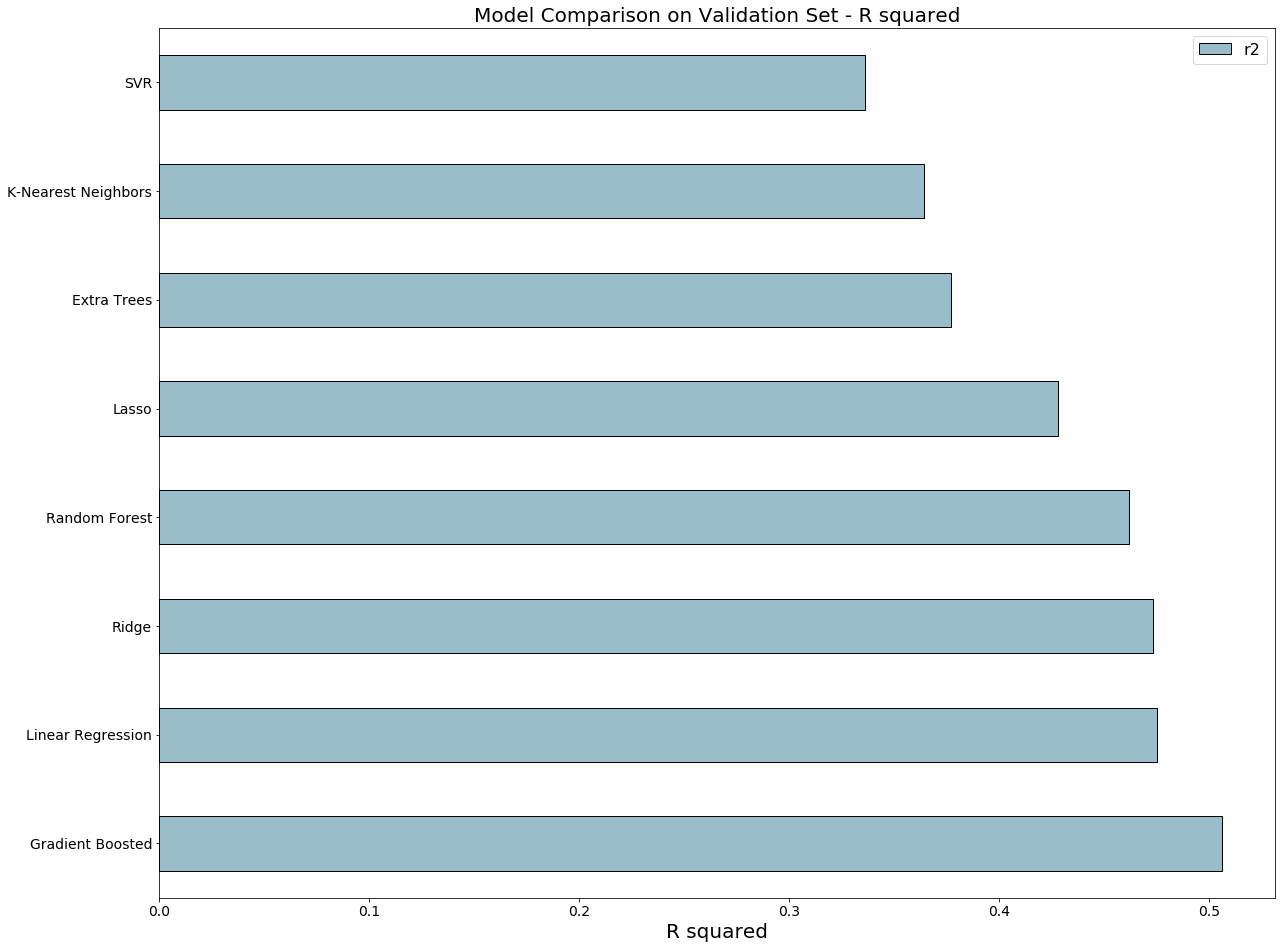

In [48]:
# Dataframe to hold the results
           
model_comparison = pd.DataFrame({'model': ['Linear Regression','Random Forest',
                                           'Extra Trees','Gradient Boosted',
                                           'Lasso', 'Ridge', 'SVR','K-Nearest Neighbors'],
                                 'r2': [linreg_r2, random_forest_r2, extra_trees_r2, 
                                         grad_boost_r2, lasso_r2, ridge_r2, svr_r2, knn_r2]})

# Horizontal bar chart of test r2
model_comparison.sort_values('r2', ascending = False).plot(x = 'model', y = 'r2', kind = 'barh',
                           
                                                           color = '#99BDCB', edgecolor = 'black')

# Plot formatting
plt.ylabel(''); plt.yticks(size = 14); plt.xlabel('R squared'); plt.xticks(size = 14)
plt.title('Model Comparison on Validation Set - R squared', size = 20);

### Results: 
#### Gradient Boosting Regressor returns the highest Adjusted R-squared value at 0.506. 

It appears that the 5-year grad rate was causing data leakage, which would explain the consistent increase in Adjusted R-squared value. 

# 8. grid search w cross val

In [49]:
# Loss function to be optimized
loss = ['ls', 'lad', 'huber']

# Number of trees used in the boosting process
n_estimators = [100, 500, 900, 1100, 1500]

# Maximum depth of each tree
max_depth = [2, 3, 5, 10, 15]

# Minimum number of samples per leaf
min_samples_leaf = [1, 2, 4, 6, 8]

# Minimum number of samples to split a node
min_samples_split = [2, 4, 6, 10]

# Maximum number of features to consider for making splits
max_features = ['auto', 'sqrt', 'log2', None]

# Define the grid of hyperparameters to search
hyperparameter_grid = {'n_estimators': n_estimators,
                       'max_depth': max_depth,
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split,
                       'max_features': max_features}

In [50]:
# Create the model to use for hyperparameter tuning
model = GradientBoostingRegressor(random_state = 19)

# Set up the random search with 4-fold cross validation
random_cv = RandomizedSearchCV(estimator=model,
                               param_distributions=hyperparameter_grid,
                               cv=4, n_iter=25, 
                               scoring = 'r2',
                               n_jobs = -1, verbose = 1, 
                               return_train_score = True,
                               random_state=19)

In [51]:
# Fit on the training data
random_cv.fit(X_train_all, y_train)

Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.6min finished


RandomizedSearchCV(cv=4, error_score='raise-deprecating',
                   estimator=GradientBoostingRegressor(alpha=0.9,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                            

In [52]:
# Find the best combination of settings
random_cv.best_estimator_


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features='log2', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=6, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=19, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [53]:
model_1 = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features='log2', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=6, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=19, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


model_1_r2 = fit_and_eval(model_1)

print('Adjusted R-squared on Validation Set: = %0.3f' % model_1_r2)

Adjusted R-squared on Validation Set: = 0.540


# 11. Model interpretation

In [30]:
feature_results = pd.DataFrame({'feature': list(X_train_all.columns), 
                                'importance': model_1.feature_importances_})

# Show the top 5 most important
feature_results = feature_results.sort_values('importance', ascending = False).reset_index(drop=True)

feature_results.head(10)

,feature,importance
0,high_school_dropout_rate_total,0.327664
1,student_attendance_rate,0.115700
2,student_chronic_truancy_rate,0.103314
3,number_student_enrollment,0.098919
4,percent_student_enrollment_white,0.057867
5,percent_9th_grade_on_track,0.052148
6,teacher_retention_rate,0.047909
7,total_number_of_school_days,0.036602
8,percent_graduates_enrolled_in_a_postsecondary_...,0.028252
9,school_type_HIGH SCHOOL,0.023305


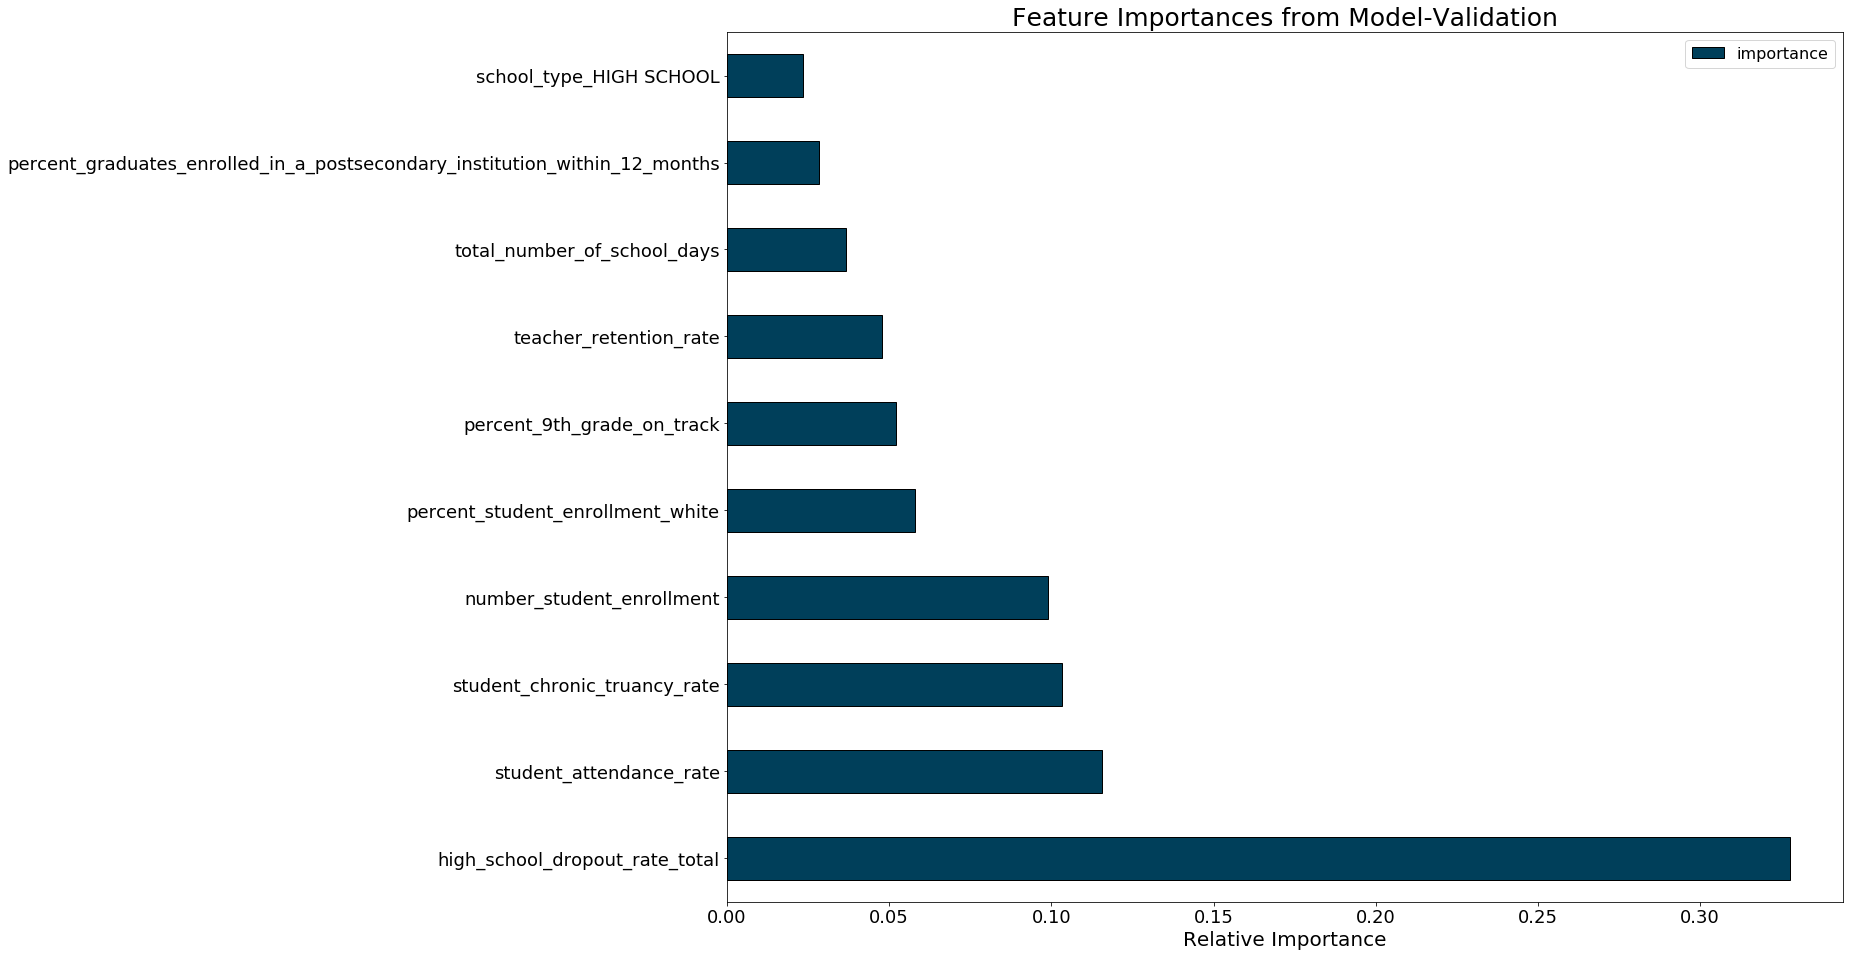

In [34]:
# Plot the 10 most important features in a horizontal bar chart
feature_results.loc[:9, :].plot(x = 'feature', y = 'importance', 
                                 edgecolor = 'k',
                                 kind='barh', color = '#003f5a');
plt.xlabel('Relative Importance'); plt.ylabel('')
plt.title('Feature Importances from Model-Validation')
plt.show();

### Evaluate on test set

In [54]:
# Select the best model
final_model = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features='log2', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=6, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=19, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

# Train the model
final_model.fit(X_train_all, y_train)
    
# Make predictions and evalute
final_model_pred = final_model.predict(X_test_all)
final_model_r2 = (r2_score(y_test, final_model_pred))
adj_r2 = round((1-(1-final_model_r2))*((3403-1)/(3403-22-1)), 3)

# Return the performance metric
print('Adjusted R-squared on Test Set: = %0.3f' % adj_r2)

Adjusted R-squared on Test Set: = 0.565


# Final model performance has an R-squared score of 0.565.

That is not as high as I had hoped, but for comparison:
- My First Simple Model (OLS Linear Regression) had an adjusted R-squared score of 0.441
- The Gradient Boosting model in it's default state had a score of 0.506.
- The hypertuned Gradient Boosting model had a score of 0.540.

So, the model did improve by around 12 percentage points. That is definitely more believable that the almost 25 percentage points increase I got with the 5-year graduation rate included.

As with the earlier version of this projects, the consistency of the final validation score and the test set score suggest that the is neither overfit nor underfit... which is a good result.

My gut tells me this current feature set is not the best for making the predictions I want to do. Going to check the feature importances to see what comes up.


In [57]:
feature_results_2 = pd.DataFrame({'feature': list(X_train_all.columns), 
                                'importance': final_model.feature_importances_})

# Show the top 5 most important
feature_results_2 = feature_results.sort_values('importance', ascending = False).reset_index(drop=True)

feature_results_2.head()

,feature,importance
0,high_school_dropout_rate_total,0.327664
1,student_attendance_rate,0.115700
2,student_chronic_truancy_rate,0.103314
3,number_student_enrollment,0.098919
4,percent_student_enrollment_white,0.057867


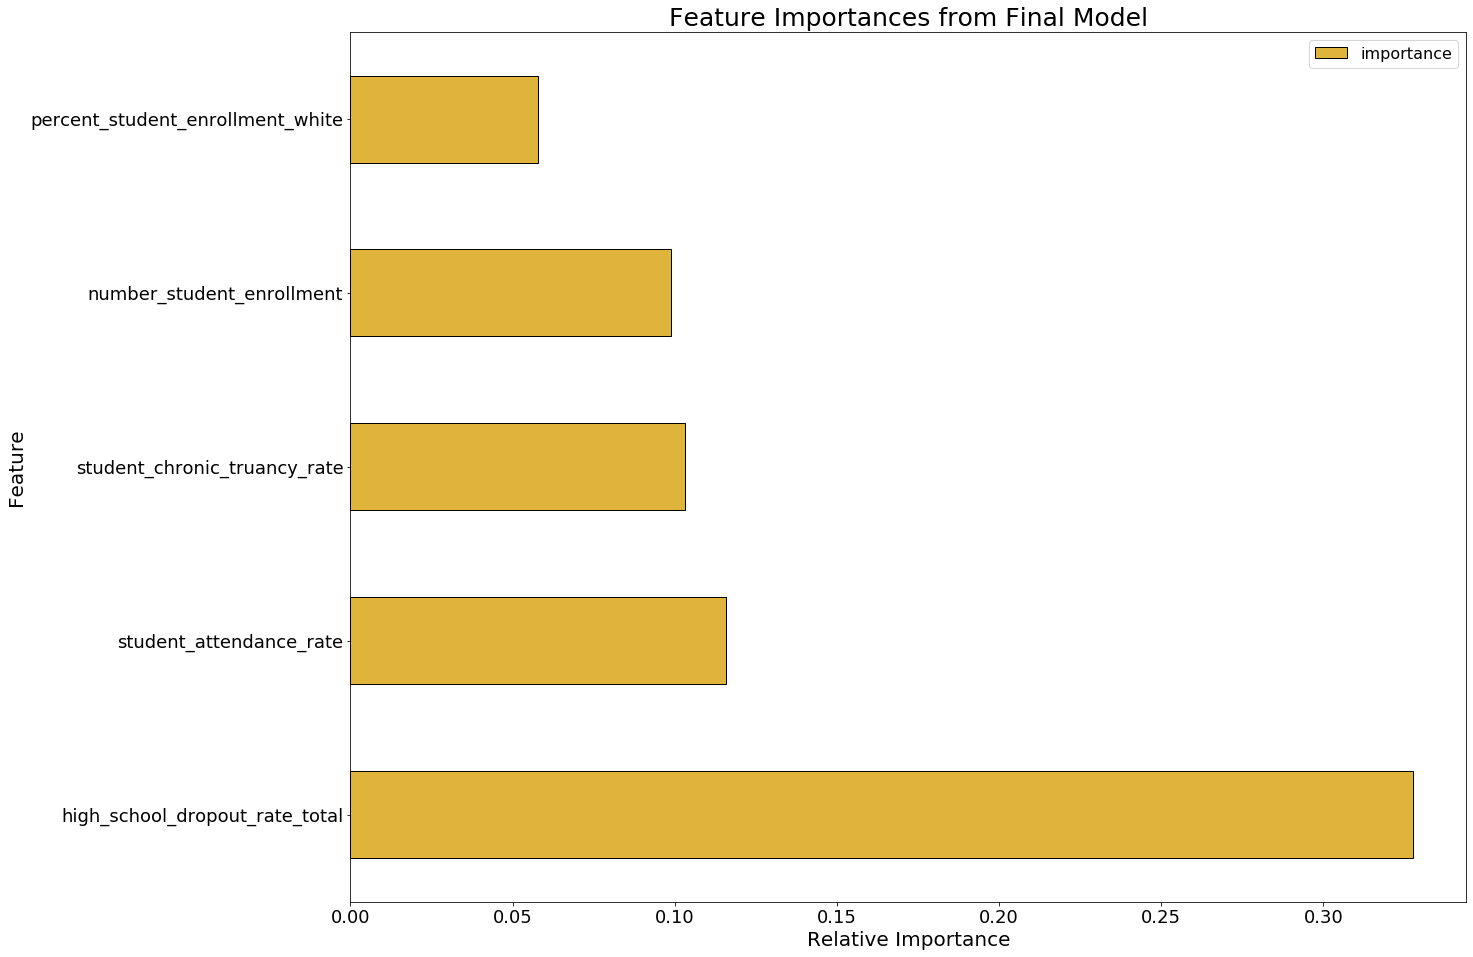

In [58]:
# Plot the  most important features in a horizontal bar chart
feature_results_2.loc[:4, :].plot(x = 'feature', y = 'importance', 
                                 edgecolor = 'k',
                                 kind='barh', color = '#deb53a');
plt.xlabel('Relative Importance'); plt.ylabel('Feature')
plt.title('Feature Importances from Final Model')
plt.savefig('../../reports/figures/feature_importance.png')
plt.show();

In this model, the dropout rate is the most important feature and its relative importance is 0.32.
In the previous model, it was second with a relative importance of 0.199.

Both of these models are attaching a significant amount of importances to a single feature.

I think part of that is because my features are largely made up of student demographic information... not all that useful in this scenario.

I need to include other data that is not only quantifiable, but are factors that can be changed in the real world to respond to the needs of students. such as:
teacher/student ratio
teacher salary
other financial information
college prep and advanced coursework.
Most of this information is recorded at the district level so I will have to go back to my data source and figure out how best to incorporate that information into the next iteration of this project.